# Topological Data Analysis Tutorial

Me following along Brandon Brown's [tutorial][tut-page].  The basics of TDA (set theory, metric spaces, simplicial complexes, etc.) were covered previously.  We will now construct a [Vietoris-Rips complex][vr-wiki] on a toy data set.

[tut-page]: http://outlace.com/TDApart2.html
[vr-wiki]: https://en.wikipedia.org/wiki/Vietoris%E2%80%93Rips_complex

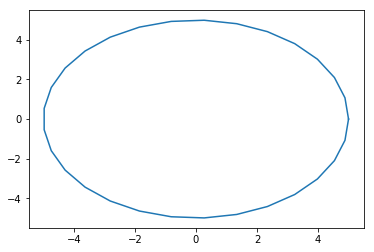

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Number of points to generate
n = 30

# Generate space of parameter
theta = np.linspace(0, 2.0 * np.pi, n)

a, b, r = 0.0, 0.0, 5.0

x = a + r * np.cos(theta)
y = b + r * np.sin(theta)

# Code to plot the circle for visualization
plt.plot(x, y)
plt.show()

We will now sample from this ellipse.

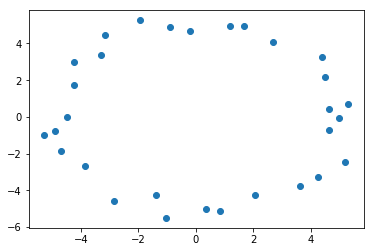

In [4]:
# The calls to np.random.uniform are to add some noise to the points.
x2 = np.random.uniform(-0.75, 0.75, n) + x
y2 = np.random.uniform(-0.75, 0.75, n) + y

fig, ax = plt.subplots()
ax.scatter(x2, y2)
plt.show()

As expected, the sampled points look circular, hinting at something going on with the data this was sampled from.  We would like our simplicial copmlex to capture this property.  

The construction of the VR complex will follow the following steps:

1. Define a distance function.  For this particular data set, we will use the Euclidean distance metric, $d(a, b) = \sqrt{(a_1 - b_1)^2 + (a_2 - b_2)^2}$.
2. Choose some $\epsilon$ to build our simplicial complex.
3. Create a collection of the 0-simplices of the VR complex.
4. Calculate distance for each pair of points.  If the distance between the points is less than $\epsilon$, add an edge between the points: this generates a 1-complex.
5. Once we've discovered all 1-simplices, iterate through each vertex and attempt to build higher dimensional simplices incrementally.  In other words, we'll add all 2-simplices to our graph, than add all 3-simplices to that graph, etc.

There are currently no polynomial-time algorithms for constructing a VR complex - there is a lot of work to be done in this area.  We will use the algorithm described in the paper ["Fast Construction of the Vietoris-Rips Complex"][vr-const-paper] by Afra Zomorodian:

[vr-const-paper]: http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.210.426

1. Construct the **neighborhood graph** of the point-set data.  The neighborhood graph is an undirected weighted graph $(G, w)$.  Here, $G = (V, E)$, where $V$ is a set of vertices, $E$ is the edge set, and $w: E \to \mathbb{R}$.  The edges are created by connecting points that are within $\varepsilon$ of each other; that is 

$$E_{\varepsilon} = \{ \{u, v\} \mid d(u, v) \leq \varepsilon, u \neq v, u, v \in V \}.$$ 

The weight function $w$ in this case is the distance between the two   points (i.e., $w(\{u, v\}) = d(u, v)).
    
2. Perform a **Vietoris-Rips expansion** on the neighborhood graph from step 1.  Given a neighborhood graph $(G, w), the weight-filtered Vietoris-Rips (VR) complex $(R(G), w)$ is given by

$$R(G) = V \cup E \cup \{ \sigma \mid \binom{\sigma}{2} \subseteq E\}.$$

For $\sigma \in R(G)$, 

$$
w(\sigma)=
    \begin{cases}
        0, &\sigma = \{v\}, v \in V \\
        w(\{u, v\}), &\sigma = \{u, v\} \in E \\
        \max_{\tau \subset \sigma}{w(\tau)}, &\textit{otherwise}
    \end{cases}
$$

So, if the simplex is an 0-simplex (a vertex), then the weight of that simplex is 0.  If the simplex is a 1-simplex (an edge), then the weight is the distance (in this case, the Euclidean distance).  For higher dimensions, the weight is the weight of the longest edge in that simplex.

Let's do a brief example on a smaller data set before we move on to the point cloud above.

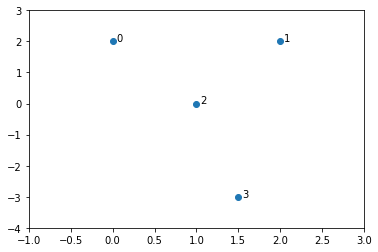

In [5]:
raw_data = np.array(
        [[0, 2], [2, 2], [1, 0], [1.5, -3.0] ]
    ) 
plt.axis([ -1,3 , -4,3 ])
plt.scatter(raw_data[ :, 0], raw_data[ :, 1]) 
for i, txt in enumerate(raw_data):
    plt.annotate(i, (raw_data[i][0] + 0.05, raw_data[i][1])) 
plt.show()

Each vertex in our simplicial complex is labeled by its position in the `raw_data` list.  We'll now construct the neighborhood graph.

In [38]:
nodes = [x for x in range(raw_data.shape[0])]
edges = []
weights = []
eps = 3.1
for i in range(raw_data.shape[0]):
    for j in range(raw_data.shape[0] - i):
        a = raw_data[i]
        b = raw_data[j + i]
        if (i != j + i):
            dist = np.linalg.norm(a - b)
            if dist <= eps:
                edges.append({i, j + i})
                weights.append([len(edges) - 1, dist])
print("Nodes: {}".format(nodes))
print("Edges: {}".format(edges))
print("Weights: {}".format(weights))

Nodes: [0, 1, 2, 3]
Edges: [{0, 1}, {0, 2}, {1, 2}, {2, 3}]
Weights: [[0, 2.0], [1, 2.23606797749979], [2, 2.23606797749979], [3, 3.0413812651491097]]


Our completed neighborhood graph.  So there is an edge between vertices `0` and `1` with weight 2.0, an edge between vertices `0` and `2` with weight 2.236, etc.  We'll now start building up higher dimensional simplices.  We'll be using the following two functions.

In [41]:
def lower_nbrs(node_set, edge_set, node):
    return {x for x in node_set if {x, node} in edge_set and node > x}

def rips(nodes, edges, k):
    # k is the max dimensions for the simplices we want to find.
    
    # Add all 0-simplices (vertices) to the VR complex
    VR_complex = [{n} for n in nodes]
    
    # Add all 1-simplices (edges) to the VR complex
    for edge in edges:
        VR_complex.append(edge)
        
    # Add higher dimensional simplices.
    for i in range(k):
        for simplex in [x for x in VR_complex if len(x) == i + 2]:
            nbrs = set.intersection(*[lower_nbrs(nodes, edges, z) for z in simplex])
            for nbr in nbrs:
                VR_complex.append(set.union(simplex, {nbr}))
    return VR_complex
    

To test, we'll call it on `nodes` and `edges` to find all simplices up to 3 dimensions:

In [42]:
VR_complex = rips(nodes, edges, 3)
VR_complex

[{0}, {1}, {2}, {3}, {0, 1}, {0, 2}, {1, 2}, {2, 3}, {0, 1, 2}]

It works!  Our function successfully found the 2-simplex created by vertices `0`, `1`, and `2`.  A visualization:

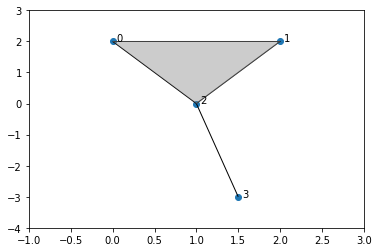

In [44]:
plt.clf()
plt.axis([-1,3, -4,3])
plt.scatter(raw_data[ :, 0], raw_data[ :, 1])
for i, txt in enumerate(raw_data):
    plt.annotate(i, (raw_data[i][0] + 0.05, raw_data[i][1]))
    
# Adding edges.  VR_complex contains point sets of different sizes.  
# Since we're only graphing edges, we check that the sets only have two
# elements in them before drawing them.
for edge in [member for member in VR_complex if len(member) == 2]:
    pt1, pt2 = [raw_data[pt] for pt in [n for n in edge]]
    line = plt.Polygon([pt1, pt2], closed = None, fill = None)
    plt.gca().add_line(line)
    
# Add triangles.  Similar to above, we check to see if the member has 3 
# elements in it before going further.
for triangle in [member for member in VR_complex if len(member) == 3]:
    pt1, pt2, pt3 = [raw_data[pt] for pt in [n for n in triangle]]
    line = plt.Polygon([pt1, pt2, pt3], closed = False, color = 'gray',
                      alpha = 0.4, fill = True, edgecolor = None)
    plt.gca().add_line(line)
plt.show()